# Case Study 4 : Data Science in NYC Taxi and Uber Data

**Required Readings:** 
* [Analyzing 1.1 Billion NYC Taxi and Uber Trips](http://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/) 
* Please download the NYC taxi and Uber dataset from [here](https://github.com/toddwschneider/nyc-taxi-data).
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.


** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem: pick a data science problem that you plan to solve using Uber/Taxi Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

Many people who travel often in the New York City have access to both the Uber transportation system through the Uber app and taxis around the city. The Uber application tells the user exactly how much their trip is going to cost, but for the taxi system, the cost of the trip is not predetermined but rather accumulated during the trip based on time and distance, mostly. If someone wants to go from point A to point B in New York City, they have no way of knowing whether it is better to use Uber or a taxi. We want to design an application that will give the user a good estimate at how much their trip will cost, taking into account traffic and the time of day. If the user was able to know which trip would be more cost efficient then it would be a very powerful tool for the average user. 

# Data Collection/Processing: 

In [2]:
import shapefile as shp
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.geometry import Point
from descartes import PolygonPatch
import pprint
import csv
from collections import Counter

pp = pprint.PrettyPrinter(indent=4)

uber_data = []
with open('uber-raw-data-aug14.csv') as f:
    reader = csv.reader(f)
    for counter, line in zip(range(5001), reader):
        if line[1] != 'Lat':
            uber_data.append(Point(float(line[2]), float(line[1])))

# Data Exploration: Exploring the Uber/Taxi Dataset

** plot the spatial distribution of the pickup locations of 5000 Uber trips** 
* collect a set of 5000 Uber trips
* plot the distribution of the pickup locations using a scatter plot figure.

5267


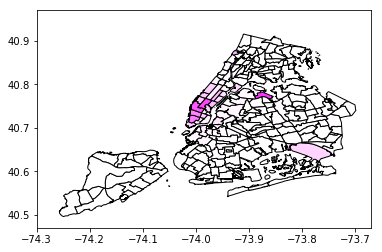

In [3]:
sf = shp.Reader("nynta.shp")
plt.figure(10)
ax = plt.axes() # add the axes
ax.set_aspect('equal')

def scale_y(x):
    OldMax = 1067382.508606
    OldMin = 913174.999355
    NewMax = -73.699215
    NewMin = -74.257159
    OldRange = (OldMax - OldMin)  
    NewRange = (NewMax - NewMin)  
    return(((x - OldMin) * NewRange) / OldRange) + NewMin

def scale_x(x):
    OldMax = 120121.779352
    OldMin = 272844.294006
    NewMin = 40.915568
    NewMax = 40.495992
    OldRange = (OldMax - OldMin)  
    NewRange = (NewMax - NewMin)  
    return(((x - OldMin) * NewRange) / OldRange) + NewMin

total = 0
numitems = len(uber_data)
for shape in list(sf.iterShapes()):
    icolor = 0; R = 1; G = 1; B = 1
    nparts = len(shape.parts)
    if nparts == 1:
        polygon = Polygon([scale_y(p[0]), scale_x(p[1])] for p in shape.points)
        for point in uber_data:
            if polygon.contains(point):
                icolor += 1
        total += icolor
        G -= icolor/800.0
        patch = PolygonPatch(polygon, facecolor=[R,G,B], alpha=1.0, zorder=2)
        ax.add_patch(patch)

    else: 
        for ip in range(nparts): 
            i0=shape.parts[ip]
            if ip < nparts-1:
                i1 = shape.parts[ip+1]-1
            else:
                i1 = len(shape.points)
            polygon = Polygon([scale_y(p[0]), scale_x(p[1])] for p in shape.points[i0:i1+1])
            for point in uber_data:
                if polygon.contains(point):
                    icolor += 1
            total += icolor
            G -= icolor/800.0
            patch = PolygonPatch(polygon, facecolor=[R,G,B], alpha=1.0, zorder=2)
            ax.add_patch(patch)

print total
            
plt.xlim(-74.3,-73.67)
plt.ylim(40.47,40.97)
ax.set_aspect('auto')
plt.savefig('uber_pickup_rate.png')
plt.show()

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

In order to filter out any data that isn’t relevant to the trip we looked at the trips that fulfilled two requirements: the first one being that the start time of the trip must be within 30 minutes of the current time of day, and the second one being that both the start and end location must be within a certain distance set by boundaries around the start and end locations, in this case we did .005 latitude and longitude away from the starting and ending locations in order to have relavant trip data. Now that we have the relevant data in our hands, we display boxplots for the time, fare cost, and distance. We also made a function that uses the information on the NYC Taxi and Limousine website which has the information for how the fare is calculated for the trip.

Write codes to implement the solution in python:

In [4]:
import datetime as DT
import csv
import pprint
import numpy as np

pp = pprint.PrettyPrinter(indent = 4)

numlines = 500000
file = 'yellow_tripdata_2016-01.csv'
boxsize = .005
timerange = .5

# interpreting the time data in hours
def hour(x):
    if '.' in x:
        x = x.split('.')
        x = x[0]
    t1 = DT.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    return (t1.hour) + float(t1.minute / 60.0) + float(t1.second / 360.0)

# loading the trips and only the data from the trips that we care about
trips = []
with open(file, 'r') as f:
    reader = csv.reader(f)
    i = 0
    for l in reader:
        if l[0] != 'VendorID':
            trips.append([[hour(l[1]),float(l[5]),float(l[6]),float(l[9]),float(l[10])],[float(l[4]),float(l[12]), 
                                                                                         hour(l[1]), hour(l[2])]])
        else:
            print l
        if i > numlines - 1:
            break
        i+=1

print trips[0]
print 'done'

# function to find relavant trips according to locaiton and time
def find_trips(src, dest, time):
    outtrips = []
    # checking that the time is inside the time range
    for trip in trips:
        time1 = trip[0][0] <= time + float(timerange)
        time2 = trip[0][0] >= time - float(timerange)
        time3 = (time and time2)
        
        # checking that the start and end locations are within the boundary
        if  ((time3) and
            (trip[0][1] <= src[0] + boxsize) and   # picking long ceiling
            (trip[0][1] >= src[0] - boxsize) and   # pickup long floor 
            (trip[0][2] >= src[1] - boxsize) and   # pickup lat floor
            (trip[0][2] <= src[1] + boxsize) and   # pickup lat ceiling
            (trip[0][3] <= dest[0] + boxsize) and  # dropoff long ceiling
            (trip[0][3] >= dest[0] - boxsize) and  # dropoff long floor
            (trip[0][4] >= dest[1] - boxsize) and  # dropoff lat floor
            (trip[0][4] <= dest[1] + boxsize)):    # dropoff lat ceiling
            outtrips.append(trip[1])
        
    return outtrips

# example trip from 'The World Trade Center' to 'The Ludlow Hotel'
start1 = [-74.011769, 40.709609]
end1 = [-73.987114, 40.721697] 
start2 = [-73.990371, 40.734695]
end2 = [-73.981842, 40.7324066]

# finding the relevant trips for our example trip
nearby_trips = find_trips(start1, end1, 9)
print(len(nearby_trips))

['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
[[0.0, -73.99037170410156, 40.73469543457031, -73.98184204101562, 40.73240661621094], [1.1, 7.5, 0.0, 0.0]]
done
247


In [5]:
# function to find the approximate cost given the means of the dataset
def approxCost(lot):
    #finding the averge distance and time of trip
    avg_dist = np.mean(lot, axis = 0)[0]
    time_diff = []
    for trip in lot:
        if (trip[3]-trip[2] > 0):
            time_diff.append(trip[3]-trip[2])
    avg_time = np.mean(time_diff)
    # checking to see if we should use the time as the cost determination or the distance
    if (avg_dist/5 > avg_time*60):
        cost_def = avg_dist/5
    else:
        cost_def = avg_time*60
    # given the function we found for fares online, we input our averages
    fare = 2.5+cost_def*.5
    return fare
print("The approximate cost for this example trip is $%.2f" % approxCost(nearby_trips) + ".")

The approximate cost for this example trip is $8.28.


In [6]:
print("(average trip distance, average time of trip)")
print(np.mean(nearby_trips, axis = 0)[0], np.mean(nearby_trips, axis = 0)[1])
print ("(distance traveled, time of trip, start time, end time)")
pp.pprint(nearby_trips)

(average trip distance, average time of trip)
(2.941012145748986, 11.935222672064777)
(distance traveled, time of trip, start time, end time)
[   [4.0, 15.5, 11.597222222222223, 11.894444444444444],
    [2.95, 11.0, 11.661111111111111, 11.822222222222221],
    [3.9, 16.5, 11.700000000000001, 12.077777777777778],
    [2.4, 15.5, 11.683333333333334, 12.163888888888888],
    [3.6, 12.0, 8.583333333333334, 8.722222222222223],
    [2.8, 9.5, 9.891666666666667, 9.894444444444446],
    [1.5, 8.0, 10.424999999999999, 10.641666666666667],
    [4.6, 15.5, 10.525, 10.791666666666666],
    [2.2, 11.0, 10.533333333333335, 10.780555555555555],
    [1.8, 9.5, 11.272222222222222, 11.419444444444444],
    [4.37, 15.5, 11.327777777777778, 11.494444444444445],
    [2.7, 9.5, 11.258333333333333, 11.380555555555555],
    [3.1, 13.0, 11.355555555555556, 11.616666666666667],
    [4.6, 15.5, 11.430555555555555, 11.655555555555555],
    [3.4, 11.5, 11.491666666666667, 11.597222222222223],
    [4.16, 13.5, 11.5

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


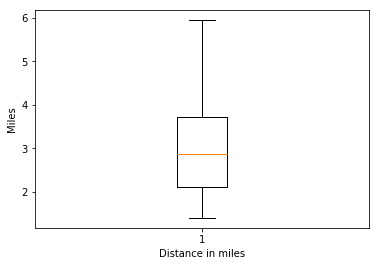

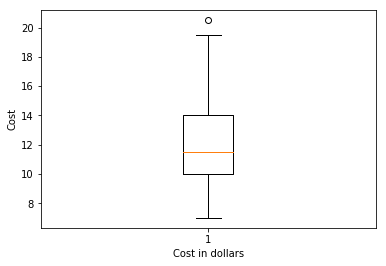

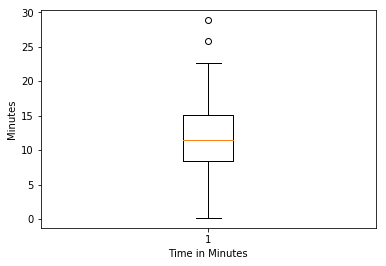

In [7]:
import matplotlib.pyplot as plt 
# displaying box plots of the time, distance, and cost
dist=[]
cost=[]
time = []
for trip in nearby_trips:
    dist.append(trip[0])
    cost.append(trip[1])
    if (trip[3]-trip[2] > 0):
        time.append(60*(trip[3]-trip[2]))
plt.figure(1)
plt.boxplot(dist)
plt.ylabel('Miles')
plt.xlabel('Distance in miles')
plt.show()
plt.figure(2)
plt.ylabel('Cost')
plt.xlabel('Cost in dollars')
plt.boxplot(cost)
plt.show
plt.figure(3)
plt.boxplot(time)
plt.ylabel('Minutes')
plt.xlabel('Time in Minutes')
plt.show()

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 4".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (10 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect/process
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    
    (1) plot the spatial distribution of the pickup locations of 5000 Uber trips (10 points):
       0: missing answer
       4: okay, but with major problems
       7: good, but with minor problems
      10: perfect
    

    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9


